<a href="https://colab.research.google.com/github/tusharsingh440/Thesis_DSS/blob/main/Copy_of_GradCAM_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Cells=np.load("/content/drive/My Drive/data/projKD/Копия Cells.npy")
labels=np.load("/content/drive/My Drive/data/projKD/Копия labels.npy")

In [ ]:
from sklearn.model_selection import train_test_split  

#Stratification used for labels and split is 80/20. 
X_train, X_test, y_train, y_test = train_test_split(Cells, labels, test_size = 0.2)

In [ ]:
# Conversion from utf-8
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 

X_train = X_train/255.0
X_test = X_test/255.0

y_train=keras.utils.to_categorical(y_train, 2)
y_test=keras.utils.to_categorical(y_test, 2)
print(y_train.shape, X_train.shape)

(22046, 2) (22046, 64, 64, 3)


In [ ]:
import keras
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras import models
from tensorflow.keras import layers

In [ ]:
def get_model():
    model = keras.Sequential()
    model.add(Input(shape=(64,64,3), name='input'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))      

    return model

teacher = get_model()

In [ ]:
teacher.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
global_average_pooling2d_6 ( (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [ ]:
# Train and evaluate teacher on data.
teacher.fit(X_train, y_train, batch_size=20, epochs=10, verbose=1,
                  validation_split = 0.1, callbacks = [early_stop])
teacher.evaluate(X_test, y_test)

Epoch 1/10
993/993 [==============================] - 5s 5ms/step - loss: 0.5982 - categorical_accuracy: 0.6513 - val_loss: 0.2905 - val_categorical_accuracy: 0.8916
Epoch 2/10
993/993 [==============================] - 4s 4ms/step - loss: 0.2295 - categorical_accuracy: 0.9235 - val_loss: 0.1815 - val_categorical_accuracy: 0.9492
Epoch 3/10
173/173 [==============================] - 1s 3ms/step - loss: 0.2034 - categorical_accuracy: 0.9260


[0.20338061451911926, 0.9259796738624573]

In [ ]:
IMGS = 64

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

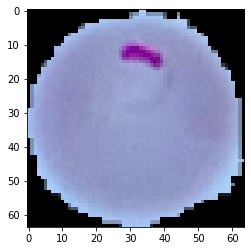

NORMAL


In [ ]:
img_arr = cv2.imread('/content/drive/MyDrive/data/projKD/cell181.png')
# img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
classes = ['Infected','NORMAL']
img_arr = cv2.resize(img_arr, (IMGS, IMGS))
plt.imshow(img_arr)
plt.show()
img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
print(classes[int(np.round(teacher.predict(img_arr)[0][0]))])

In [ ]:
lay = []
for layer in teacher.layers:
    lay.append(layer.name)
    print(layer.name)

conv2d_18
max_pooling2d_12
conv2d_19
max_pooling2d_13
conv2d_20
global_average_pooling2d_6
dense_12
dropout_5
dense_13
activation_4


In [ ]:
model_builder = teacher
img_size = (IMGS, IMGS)
def preprocess_input(img):
    img_arr = cv2.imread(img)
    #img_arr = crop_brain_contour(img_arr, False)
    img_arr = cv2.resize(img_arr, img_size)
    img_arr = img_arr.reshape(IMGS, IMGS, 3)
    return img_arr

def decode_prediction(prediction):
    return classes[int(prediction[0])]

last_conv_layer_name = lay[4]

classifier_layer_names = lay[5:]

# img_path = '/content/drive/MyDrive/infected_cell1.png'

# plt.imshow(preprocess_input(img_path))
# plt.show()

In [ ]:
print(last_conv_layer_name)

conv2d_20


In [ ]:
def get_img_array(img_path, size):
    np.seterr(divide='ignore')
    img_arr = cv2.imread(img_path)
    #img_arr = crop_brain_contour(img_arr, False)
    img_arr = cv2.resize(img_arr, (IMGS, IMGS))
    img_arr = img_arr.reshape(1, IMGS, IMGS, 3)
    return img_arr

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)

    classifier_model = keras.engine.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it

        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        prop_grad = last_conv_layer_output # propagate all layers inside the tape block
        for layer in classifier_layer_names[:-2]: # all massive without last element
            prop_grad = model.get_layer(layer)(prop_grad)

        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer

    grads = tape.gradient(prop_grad, last_conv_layer_output) 
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    last_conv_layer_output = last_conv_layer_output*pooled_grads

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
img_path1 = '/content/drive/MyDrive/data/projKD/Копия normal_cell.png'
img_path2 = '/content/drive/MyDrive/data/projKD/cell181.png'

[[0. 1.]]
Predicted: Infected


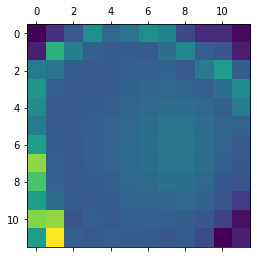

In [ ]:
img_array1 = get_img_array(img_path1, size = img_size)
img_array2 = get_img_array(img_path2, size = img_size)

preds1 = teacher.predict(img_array1)
preds2 = teacher.predict(img_array2)
print(preds1)
print("Predicted:", classes[int(np.round(teacher.predict(img_array1)[0][0]))])

# Generate class activation heatmap
heatmap1 = make_gradcam_heatmap(
    img_array1, teacher, last_conv_layer_name, classifier_layer_names
)
# Display heatmap
plt.matshow(heatmap1)
plt.show()

# print(preds2)
# print("Predicted:", classes[int(np.round(teacher.predict(img_array2)[0][0]))])

# # Generate class activation heatmap
# heatmap2 = make_gradcam_heatmap(
#     img_array2, teacher, last_conv_layer_name, classifier_layer_names
# )
# # Display heatmap
# plt.matshow(heatmap2)
# plt.show()

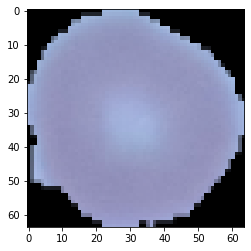

In [ ]:
plt.imshow(img_array[0])

In [ ]:
heatmap

<tf.Tensor 'Mean_15:0' shape=(14, 14) dtype=float32>

Predicted: NORMAL


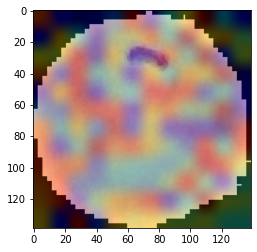

In [ ]:
import tensorflow
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tensorflow.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tensorflow.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tensorflow.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "grad_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
print("Predicted:", classes[int(np.round(teacher.predict(img_arr)[0][0]))])
plt.imshow(superimposed_img)

In [ ]:
print(tf.__version__)  # for Python 3

2.4.0
